# Importing packages 

In [1]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# Keras API 
from tensorflow import keras

# Deep learning 
from tensorflow.keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# Custom functions

In [2]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

# Reading the data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
d = pd.read_csv('/content/drive/MyDrive/Tehran.csv')

print(f'Shape of data: {d.shape}')

Shape of data: (87672, 25)


In [5]:
# Types of columns
d.dtypes

date_time                    object
Tehran_maxtempC               int64
Tehran_mintempC               int64
Tehran_totalSnow_cm         float64
Tehran_sunHour              float64
Tehran_uvIndex                int64
Tehran_moon_illumination      int64
Tehran_moonrise              object
Tehran_moonset               object
Tehran_sunrise               object
Tehran_sunset                object
Tehran_DewPointC              int64
Tehran_FeelsLikeC             int64
Tehran_HeatIndexC             int64
Tehran_WindChillC             int64
Tehran_WindGustKmph           int64
Tehran_cloudcover             int64
Tehran_humidity               int64
Tehran_precipMM             float64
Tehran_pressure               int64
Tehran_tempC                  int64
Tehran_visibility             int64
Tehran_winddirDegree          int64
Tehran_windspeedKmph          int64
Tehran_location              object
dtype: object

In [6]:
from datetime import datetime
# Converting the dt column to datetime object 
d['date_time'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['date_time']]
# Sorting by the date 
d.sort_values('date_time', inplace=True)

In [7]:
# Listing the min and the max dates 
print(f"First date {min(d['date_time'])}")
print(f"Most recent date {max(d['date_time'])}")

First date 2012-11-20 00:00:00
Most recent date 2022-11-20 23:00:00


# Column explanations

The columns that will be used in the analysis:
    
* **dt** - local datetime of the observation 

* **date** - local date of the observation

* **temp** - the observed temperature in Celcius

* **pressure** -  Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa

* **clouds_all** - cloudiness in %. 

* **wind_speed** - speed of wind in meter/sec.  

* **humidity** - concentrantion of water vapor in the air.

# Data cleaning 

In [8]:
print(f"Total unique dates in the dataset: {len(set(d['date_time']))}")

Total unique dates in the dataset: 87672


In [9]:
print(f"Number of rows in the dataset: {d.shape[0]}")

Number of rows in the dataset: 87672


In [10]:
# Features used in models
features = ['Tehran_tempC', 'Tehran_pressure', 'Tehran_windspeedKmph']

# Aggregating to hourly level
d = d.groupby('date_time', as_index=False)[features].mean()

# Creating the data column
#d['date'] = [x.date() for x in d['date_time']]

# Explanatory data analysis 

## Descriptive statistics

In [11]:
d[features].describe()

,Tehran_tempC,Tehran_pressure,Tehran_windspeedKmph
count,87672.000000,87672.000000,87672.000000
mean,17.614529,1014.724952,7.721690
std,11.244255,6.548269,4.736922
min,-13.000000,995.000000,0.000000
25%,8.000000,1010.000000,4.000000
50%,17.000000,1014.000000,7.000000
75%,27.000000,1019.000000,10.000000
max,43.000000,1040.000000,54.000000


## Snapshot of temperature data 

In [12]:
d[['date_time', 'Tehran_tempC']].head(10)

,date_time,Tehran_tempC
0,2012-11-20 00:00:00,10.0
1,2012-11-20 01:00:00,9.0
2,2012-11-20 02:00:00,9.0
3,2012-11-20 03:00:00,9.0
4,2012-11-20 04:00:00,8.0
5,2012-11-20 05:00:00,8.0
6,2012-11-20 06:00:00,7.0
7,2012-11-20 07:00:00,8.0
8,2012-11-20 08:00:00,10.0
9,2012-11-20 09:00:00,11.0


In [13]:
d[['date_time', 'Tehran_tempC']].tail(10)

,date_time,Tehran_tempC
87662,2022-11-20 14:00:00,17.0
87663,2022-11-20 15:00:00,18.0
87664,2022-11-20 16:00:00,17.0
87665,2022-11-20 17:00:00,17.0
87666,2022-11-20 18:00:00,17.0
87667,2022-11-20 19:00:00,16.0
87668,2022-11-20 20:00:00,15.0
87669,2022-11-20 21:00:00,14.0
87670,2022-11-20 22:00:00,13.0
87671,2022-11-20 23:00:00,13.0


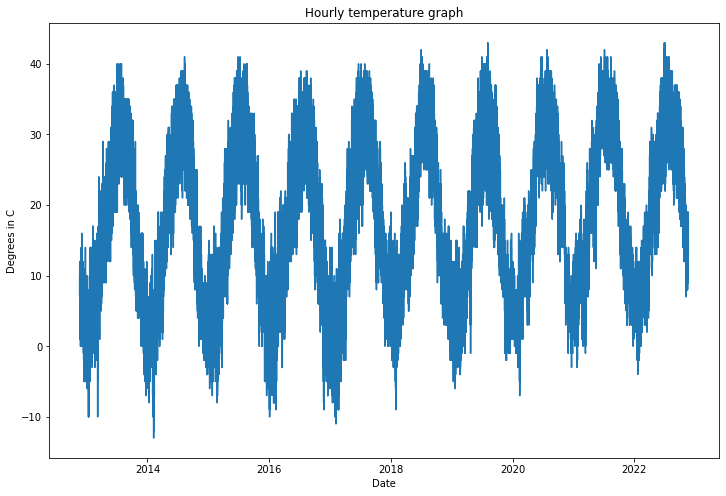

In [14]:
plt.figure(figsize=(12, 8))
plt.plot('date_time', 'Tehran_tempC', data=d)
plt.title('Hourly temperature graph')
plt.ylabel('Degrees in C')
plt.xlabel('Date')
plt.show()

## Hourly data plots

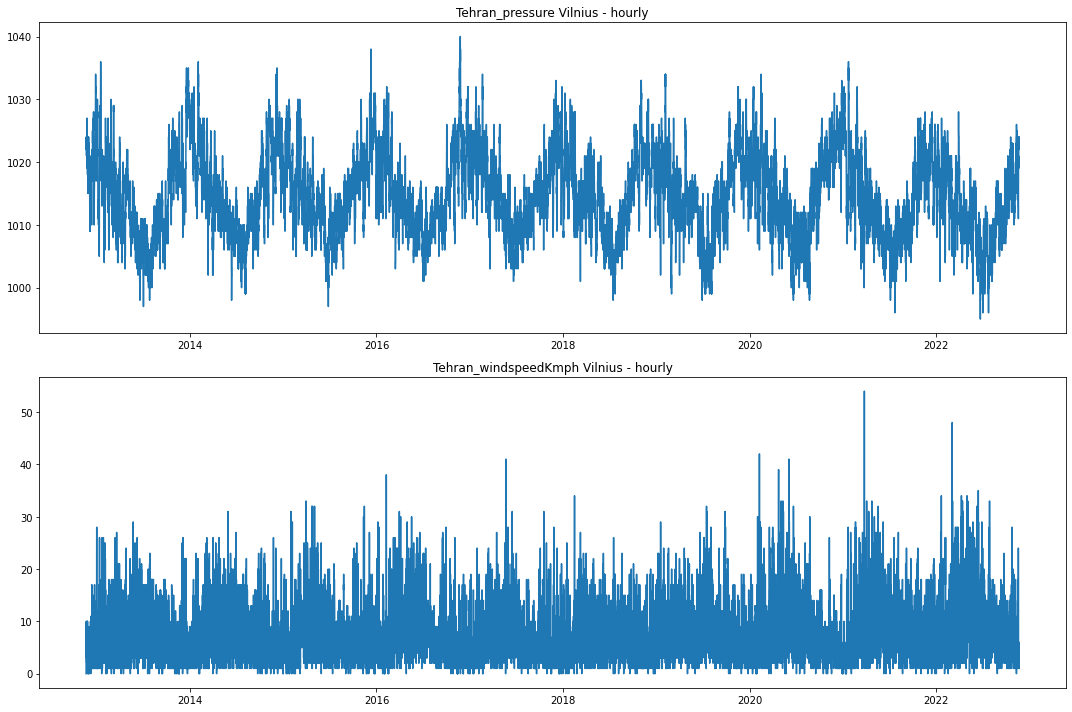

In [15]:
plot_features = d[features]
plot_features.index = d.date_time

fig, axes = plt.subplots(
    nrows=2, 
    ncols=1, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(['Tehran_pressure', 'Tehran_windspeedKmph']):
    axes[i % 2].plot(plot_features[feature])
    axes[i % 2].set_title(f'{feature} Vilnius - hourly')
        
plt.tight_layout()

plt.show()

## Daily data 

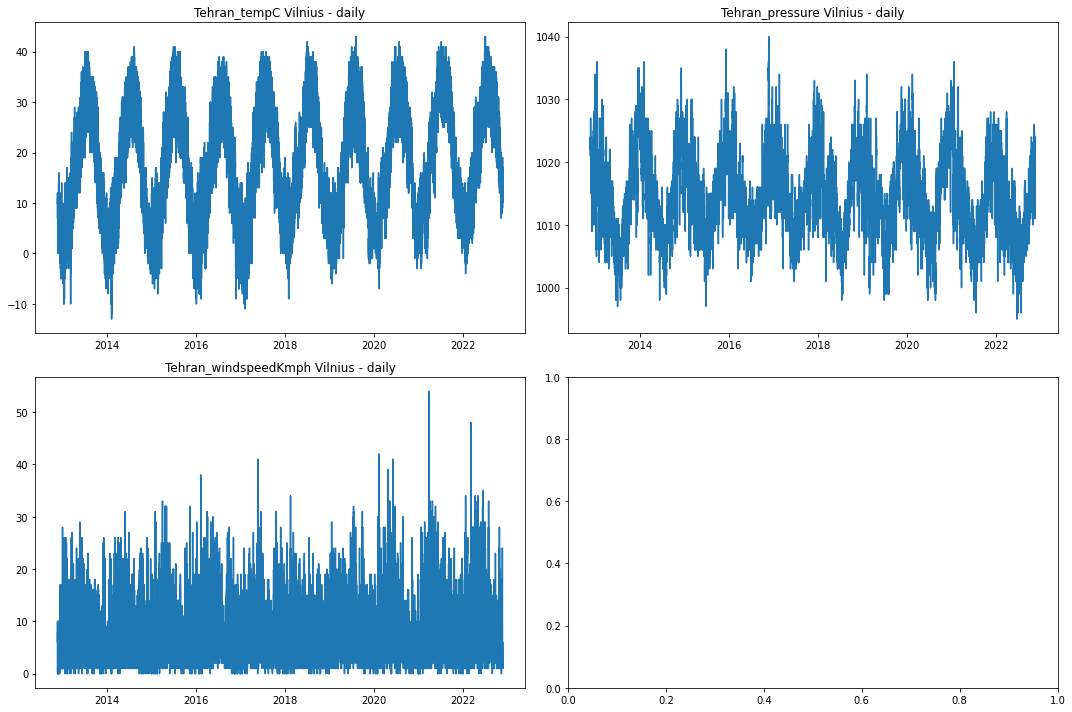

In [16]:
plot_features = d.groupby('date_time')[features].mean()

fig, axes = plt.subplots(
    nrows=2, 
    ncols=2, 
    figsize=(15, 10), 
    facecolor="w", 
    edgecolor="k"
)

for i, feature in enumerate(features):
    axes[i // 2, i % 2].plot(plot_features[feature])
    axes[i // 2, i % 2].set_title(f'{feature} Vilnius - daily')
        
plt.tight_layout()

plt.show()

## Heatmaps

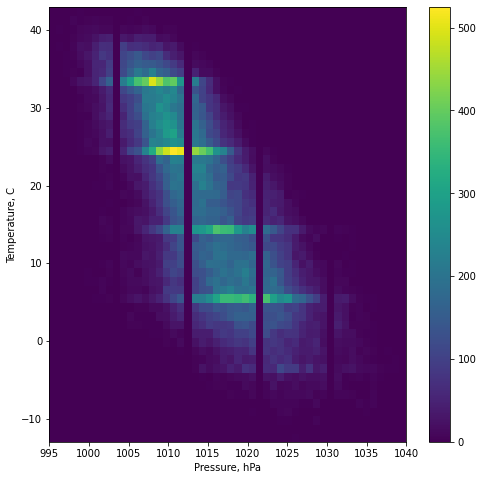

In [17]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['Tehran_pressure'], d['Tehran_tempC'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Pressure, hPa')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

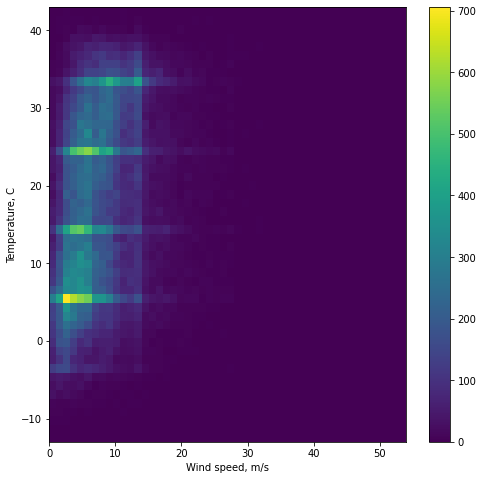

In [18]:
plt.figure(figsize=(8, 8))
plt.hist2d(d['Tehran_windspeedKmph'], d['Tehran_tempC'], bins=(50, 50))
plt.colorbar()
ax = plt.gca()
plt.xlabel('Wind speed, m/s')
plt.ylabel('Temperature, C')
ax.axis('tight')
plt.show()

# Feature engineering

In [19]:
# Extracting the hour of day
d['hour'] = [x.hour for x in d['date_time']]

# Extracting the month of the year 
d['month'] = [x.month for x in d['date_time']]

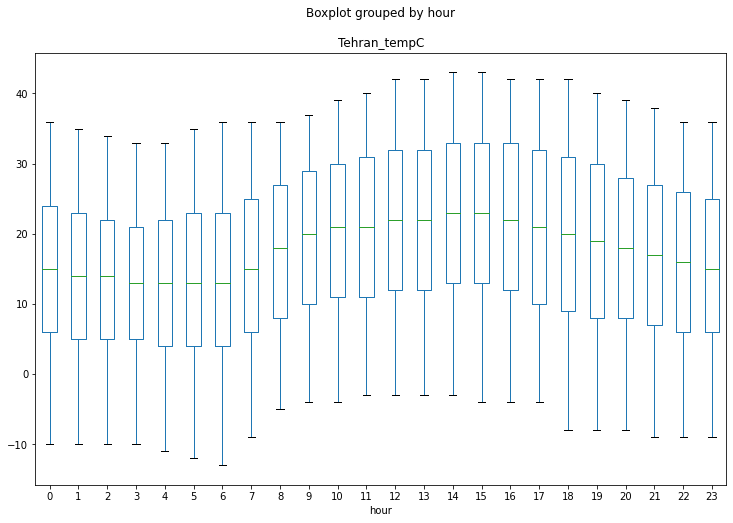

In [20]:
d.boxplot('Tehran_tempC', by='hour', figsize=(12, 8), grid=False)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


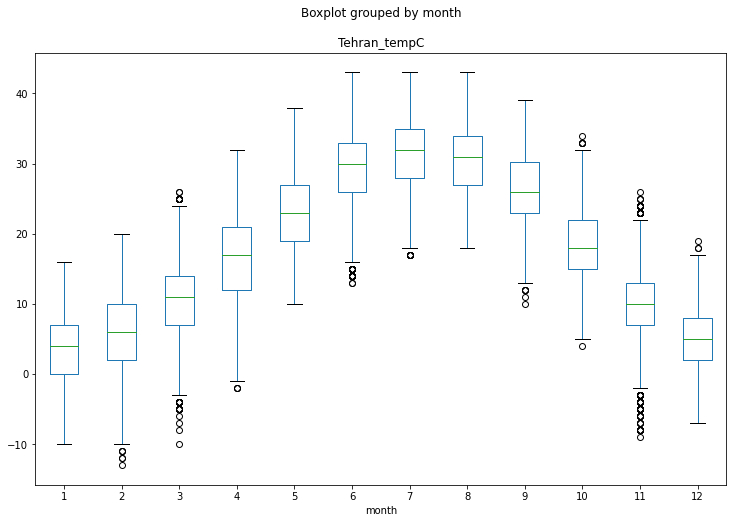

In [21]:
d.boxplot('Tehran_tempC', by='month', figsize=(12, 8), grid=False)

In [22]:
# Creating the cyclical daily feature 
d['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in d['hour']]
d['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in d['hour']]

In [23]:
dsin = d[['date_time', 'Tehran_tempC', 'hour', 'day_sin', 'day_cos']].head(25).copy()
dsin['day_sin'] = [round(x, 3) for x in dsin['day_sin']]
dsin['day_cos'] = [round(x, 3) for x in dsin['day_cos']]

dsin

,date_time,Tehran_tempC,hour,day_sin,day_cos
0,2012-11-20 00:00:00,10.0,0,0.000,1.000
1,2012-11-20 01:00:00,9.0,1,0.259,0.966
2,2012-11-20 02:00:00,9.0,2,0.500,0.866
3,2012-11-20 03:00:00,9.0,3,0.707,0.707
4,2012-11-20 04:00:00,8.0,4,0.866,0.500
5,2012-11-20 05:00:00,8.0,5,0.966,0.259
6,2012-11-20 06:00:00,7.0,6,1.000,0.000
7,2012-11-20 07:00:00,8.0,7,0.966,-0.259
8,2012-11-20 08:00:00,10.0,8,0.866,-0.500
9,2012-11-20 09:00:00,11.0,9,0.707,-0.707


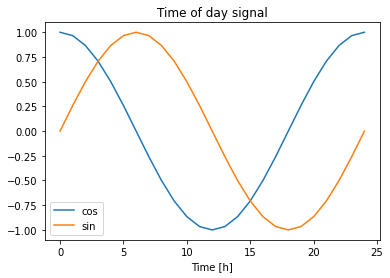

In [24]:
# Ploting the first 25 hours 
plt.plot(np.array(d['day_cos'])[:25], label='cos')
plt.plot(np.array(d['day_sin'])[:25], label='sin')
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.legend()
plt.show()

In [25]:
# Extracting the timestamp from the datetime object 
d['timestamp'] = [x.timestamp() for x in d['date_time']]

# Seconds in day 
s = 24 * 60 * 60 

# Seconds in year 
year = (365.25) * s

d['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in d['timestamp']]
d['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in d['timestamp']]

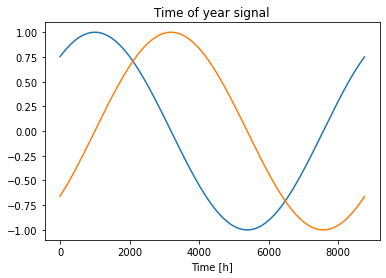

In [26]:
# Ploting the first year
plt.plot(np.array(d['month_cos'])[:24 * 365])
plt.plot(np.array(d['month_sin'])[:24 * 365])
plt.xlabel('Time [h]')
plt.title('Time of year signal')
plt.show()

# Single step forecast

## Hyper parameters

In [54]:
# Number of lags (hours back) to use for models
lag = 72

# Steps ahead to forecast 
n_ahead = 1

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 20

# Batch size 
batch_size = 100

# Learning rate
lr = 0.001

# Number of neurons in LSTM layer
n_layer = 100

# The features used in the modeling 
features_final = ['Tehran_tempC', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'Tehran_pressure', 'Tehran_windspeedKmph']

## Creating the matrices for training

In [55]:
d[features_final].head(10)

,Tehran_tempC,day_cos,day_sin,month_sin,month_cos,Tehran_pressure,Tehran_windspeedKmph
0,10.0,1.000000e+00,0.000000,-0.658031,0.752991,1023.0,0.0
1,9.0,9.659258e-01,0.258819,-0.657491,0.753462,1023.0,2.0
2,9.0,8.660254e-01,0.500000,-0.656951,0.753933,1023.0,3.0
3,9.0,7.071068e-01,0.707107,-0.656411,0.754404,1023.0,4.0
4,8.0,5.000000e-01,0.866025,-0.655870,0.754874,1022.0,4.0
5,8.0,2.588190e-01,0.965926,-0.655328,0.755344,1022.0,3.0
6,7.0,6.123234e-17,1.000000,-0.654787,0.755814,1022.0,3.0
7,8.0,-2.588190e-01,0.965926,-0.654245,0.756283,1023.0,4.0
8,10.0,-5.000000e-01,0.866025,-0.653703,0.756751,1023.0,5.0
9,11.0,-7.071068e-01,0.707107,-0.653160,0.757220,1023.0,7.0


In [56]:
# Subseting only the needed columns 
ts = d[features_final]

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [57]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead)

n_ft = X.shape[2]

In [58]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [59]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (78839, 72, 7)
Shape of the target data: (78839, 1)
Shape of validation data: (8760, 72, 7)
Shape of the validation target data: (8760, 1)


# Defining the model 

In [60]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [61]:
model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=n_layer,
    batch=batch_size,
    epochs=epochs, 
    lr=lr,
    Xval=Xval,
    Yval=Yval,
)

In [62]:
model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 72, 7)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               43200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 43,301
Trainable params: 43,301
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = model.train()

Epoch 1/20
789/789 [==============================] - 102s 128ms/step - loss: 0.1891 - val_loss: 0.3147
Epoch 2/20
789/789 [==============================] - 93s 118ms/step - loss: 0.1382 - val_loss: 0.1666
Epoch 3/20
789/789 [==============================] - 95s 120ms/step - loss: 0.1123 - val_loss: 0.1607
Epoch 4/20
789/789 [==============================] - 95s 120ms/step - loss: 0.0919 - val_loss: 0.2167
Epoch 5/20
789/789 [==============================] - 93s 118ms/step - loss: 0.0942 - val_loss: 0.1305
Epoch 6/20
789/789 [==============================] - 95s 121ms/step - loss: 0.0845 - val_loss: 0.1942
Epoch 7/20
789/789 [==============================] - 95s 121ms/step - loss: 0.0782 - val_loss: 0.1762
Epoch 8/20
789/789 [==============================] - 92s 117ms/step - loss: 0.0742 - val_loss: 0.1088
Epoch 9/20
789/789 [==============================] - 95s 120ms/step - loss: 0.0712 - val_loss: 0.1248
Epoch 10/20
789/789 [==============================] - 92s 117ms/step - 

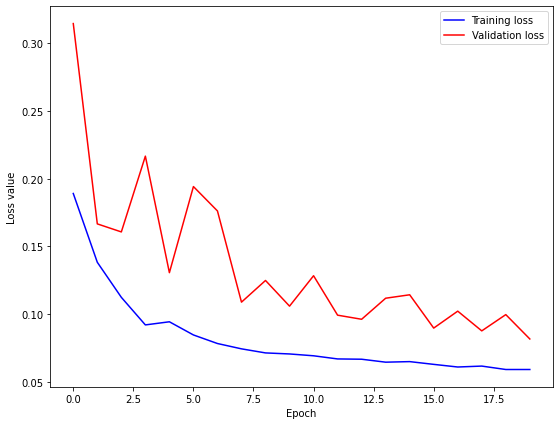

In [64]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [65]:
print(Xval[100])

[[-8.32799312e-01  1.00002418e+00  9.99898795e-01 -8.95655912e-01
   1.09419443e+00  1.07565268e+00 -1.20353681e+00]
 [-8.32799312e-01  7.07137207e-01  1.22464561e+00 -8.94871288e-01
   1.09483620e+00  1.07565268e+00 -5.53983222e-01]
 [-8.32799312e-01  3.66063104e-01  1.36592737e+00 -8.94086204e-01
   1.09547741e+00  1.22771503e+00 -1.20947497e-01]
 [-7.44444322e-01  4.55071186e-05  1.41411595e+00 -8.93300661e-01
   1.09611805e+00  1.22771503e+00  5.28606090e-01]
 [-6.56089331e-01 -3.65972090e-01  1.36592737e+00 -8.92514658e-01
   1.09675813e+00  1.22771503e+00  3.12088228e-01]
 [-5.67734340e-01 -7.07046193e-01  1.22464561e+00 -8.91728197e-01
   1.09739765e+00  1.22771503e+00  9.55703654e-02]
 [-4.79379350e-01 -9.99933164e-01  9.99898795e-01 -8.90941278e-01
   1.09803660e+00  1.22771503e+00 -3.37465359e-01]
 [-3.91024359e-01 -1.22467324e+00  7.07003039e-01 -8.90153901e-01
   1.09867499e+00  1.07565268e+00 -1.20947497e-01]
 [-3.02669368e-01 -1.36595076e+00  3.65918707e-01 -8.89366067e-0

In [66]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

274/274 [==============================] - 3s 10ms/step


In [67]:
# Creating the frame to store both predictions
days = d['date_time'].values[-len(y):]

frame = pd.concat([
    pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])
print(train_mean)
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['Tehran_tempC']) + train_mean['Tehran_tempC'] for x in frame['temp']]

# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

Tehran_tempC              17.425606
day_cos                   -0.000032
day_sin                    0.000078
month_sin                 -0.000083
month_cos                  0.000096
Tehran_pressure         1014.926239
Tehran_windspeedKmph       7.558603
dtype: float64


In [68]:
pivoted.tail(20)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2022-11-20 04:00:00,-0.708850,-0.656089,9.402851,10.0,0.597149,0.597149
2022-11-20 05:00:00,-0.701103,-0.656089,9.490540,10.0,0.509460,0.509460
2022-11-20 06:00:00,-0.706492,-0.744444,9.429542,9.0,-0.429542,0.429542
2022-11-20 07:00:00,-0.765038,-0.744444,8.766916,9.0,0.233084,0.233084
2022-11-20 08:00:00,-0.693099,-0.656089,9.581122,10.0,0.418878,0.418878
2022-11-20 09:00:00,-0.549808,-0.479379,11.202894,12.0,0.797106,0.797106
2022-11-20 10:00:00,-0.369709,-0.302669,13.241243,14.0,0.758757,0.758757
2022-11-20 11:00:00,-0.232785,-0.214314,14.790952,15.0,0.209048,0.209048
2022-11-20 12:00:00,-0.168972,-0.125959,15.513184,16.0,0.486816,0.486816


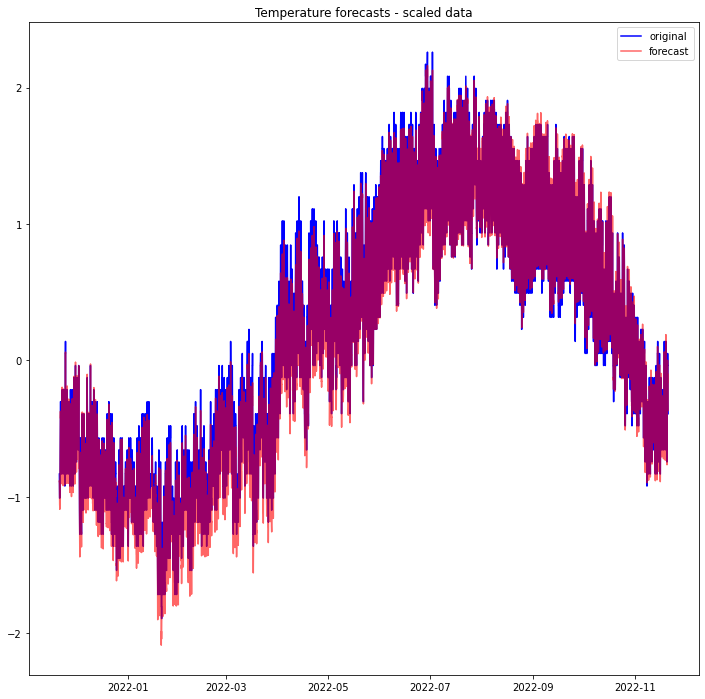

In [69]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - scaled data')
plt.legend()
plt.show()

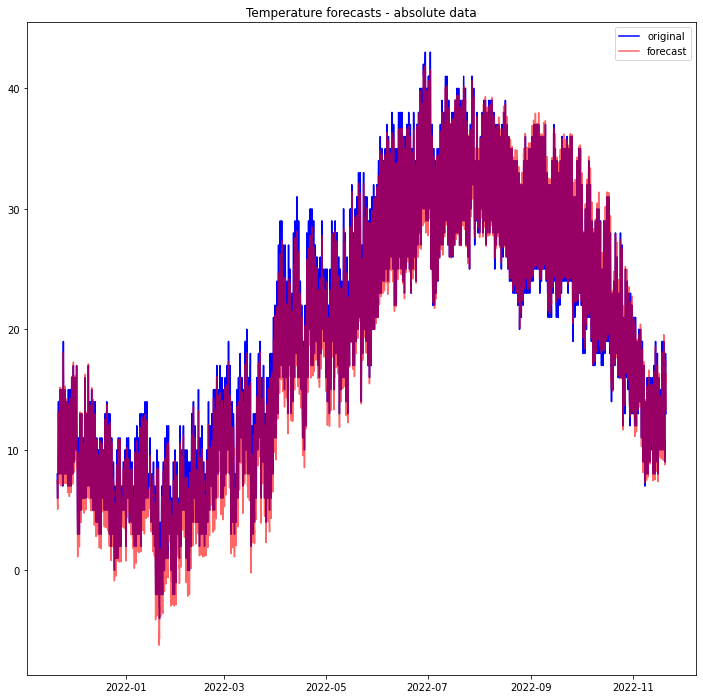

In [70]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts - absolute data')
plt.legend()
plt.show()

In [71]:
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

In [72]:
pivoted.tail(10)

,temp_forecast,temp_original,temp_absolute_forecast,temp_absolute_original,res,res_abs
day,,,,,,
2022-11-20 14:00:00,-0.017169,-0.037604,17.231289,17.0,-0.231289,0.231289
2022-11-20 15:00:00,0.000545,-0.037604,17.431776,17.0,-0.431776,0.431776
2022-11-20 16:00:00,-0.000685,0.050751,17.417850,18.0,0.582150,0.582150
2022-11-20 17:00:00,-0.052967,-0.037604,16.826122,17.0,0.173878,0.173878
2022-11-20 18:00:00,-0.160799,-0.037604,15.605691,17.0,1.394309,1.394309
2022-11-20 19:00:00,-0.132538,-0.037604,15.925539,17.0,1.074461,1.074461
2022-11-20 20:00:00,-0.101286,-0.125959,16.279250,16.0,-0.279250,0.279250
2022-11-20 21:00:00,-0.196288,-0.214314,15.204027,15.0,-0.204027,0.204027
2022-11-20 22:00:00,-0.308891,-0.302669,13.929583,14.0,0.070417,0.070417


In [73]:
print(f"Average absolute mean error: {round(pivoted['res_abs'].sum() / pivoted.shape[0], 2)} C")

Average absolute mean error: 0.92 C


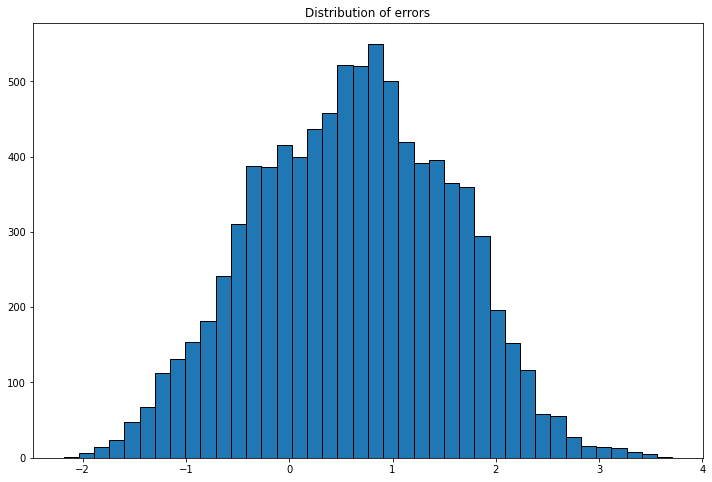

In [74]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res, bins=40, edgecolor='black')
plt.title('Distribution of errors')
plt.show()

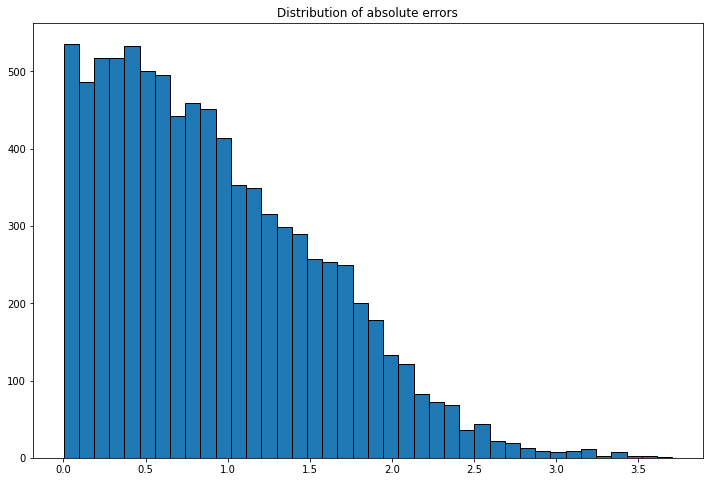

In [75]:
plt.figure(figsize=(12, 8))
plt.hist(pivoted.res_abs, bins=40, edgecolor='black')
plt.title('Distribution of absolute errors')
plt.show()

In [76]:
pivoted.res_abs.describe()

count    8760.000000
mean        0.922721
std         0.649713
min         0.000122
25%         0.393206
50%         0.813582
75%         1.358944
max         3.708904
Name: res_abs, dtype: float64

## About Me:
Javad Abdollahzadeh